# Spectral analysis: envelope and details

**Optional material:** 

Linear predictive modeling of audio signals have been much more popular in speech processing than music signal processing. Yet it provides some useful representation of the spectral envelope which could be exploited (and was exploited in some studies) in music signal processing. Consider this notebook as an "optional/extra material" for our course. 

In this notebook we will exemplify the use of linear predictive analysis for decomposing a signal into a filter and an excitation component. The theory of linear prediction has been reviewed in large number of resources, most famous of those resources being [Makhoul, J. (1975). "Linear prediction: A tutorial review". Proceedings of the IEEE. 63 (5): 561–580.](https://ieeexplore.ieee.org/document/1451722) In this notebook, we only exemplify use of linear prediction for decomposing the spectrum of an audio signal into envelope and detail components. The envelope component will be considered to be a timbre related feature since it relates with the LTI system that produces the sound. The detail component will be considered to be a pitch and harmonics related feature. 

In [ ]:
!pip install spectrum
!pip install pysoundfile
!pip install librosa==0.8.0
import os, sys,shutil
import numpy as np
import matplotlib.pyplot as plt
from spectrum.window import create_window
from spectrum.linear_prediction import poly2lsf, lsf2poly
import librosa, librosa.display
from scipy.signal import lfilter, freqz
import soundfile as sf
import urllib.request
from IPython.display import Audio


In [ ]:
url = 'https://github.com/barisbozkurt/dataDumpForCourses/raw/master/exampleSpeech.wav'
urllib.request.urlretrieve(url,'exampleSpeech.wav')
speech_sig, fs = sf.read('exampleSpeech.wav')
print('Sampling frequency: ', fs, 'Hz')
Audio(speech_sig, rate=fs)

Sampling frequency:  44100 Hz


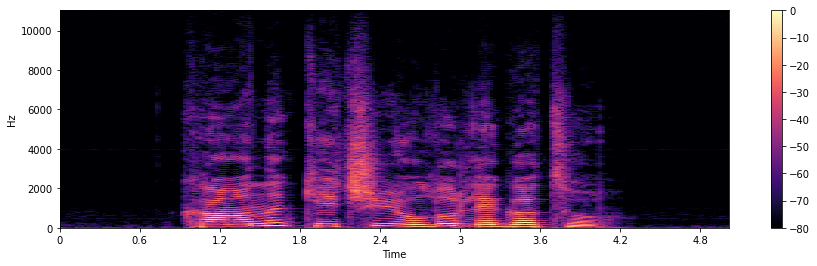

In [ ]:
#Plotting spectrogram using Librosa functions as in https://librosa.org/doc/main/auto_examples/plot_display.html
D = librosa.stft(speech_sig)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig = plt.figure(figsize=(15,4))
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
plt.colorbar();

Let's take a portion of the signal for more localized analysis

In [ ]:
start_sec = 1.2;stop_sec = 1.25
speech_win = speech_sig[int(start_sec*fs):int(stop_sec*fs)]
speech_win *= create_window(speech_win.size, name = 'hanning')
fft_n = pow(2,int(np.log2(speech_win.size) + 1))
amp_spec = 20 * np.log10(np.abs(np.fft.fft(speech_win,n=fft_n)[:fft_n//2]))

r =  0.9928400028512286 , freq =  8762.014681854875 Hz
r =  0.9924462637756216 , freq =  2209.822565819853 Hz
r =  0.9924114905910963 , freq =  334.68154315545735 Hz
r =  0.9887650251507794 , freq =  3689.705701061509 Hz
r =  0.9877227007196583 , freq =  11510.020095678363 Hz
r =  0.9857092696705878 , freq =  10072.529141729163 Hz
r =  0.9830399733967451 , freq =  6521.139649662867 Hz
r =  0.9779733826120113 , freq =  4829.077112838217 Hz
r =  0.9764057060907222 , freq =  12712.014335519774 Hz
r =  0.9704076090176514 , freq =  2773.9827361747057 Hz
Spectrum plots shifted and scaled for better viewing of the seperate components


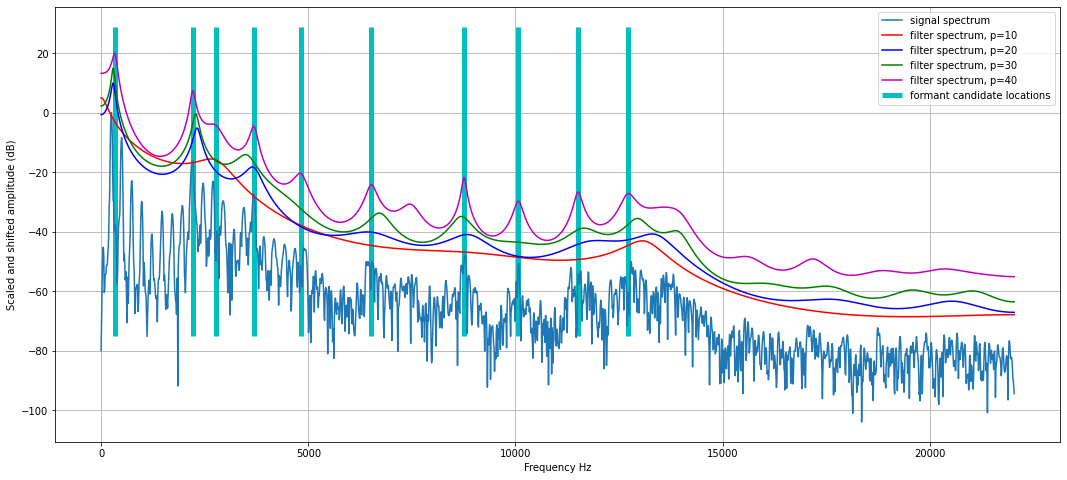

In [ ]:
def lpc_spectrum(speech_sig, num_coefs, num_freq_point):
  a = librosa.lpc(speech_sig, num_coefs)
  w, h = freqz(1, a, num_freq_points)
  return w, 20 * np.log10(np.abs(h))

def estimate_formants_lpc(speech_sig, fs, num_coefs, num_formants):
  a = librosa.lpc(speech_sig, num_coefs)
  roots = np.roots(a)
  roots_r = np.abs(roots)
  roots_theta = np.angle(roots)
  #drop roots at negative frequencies
  positive_freq_indexes = roots_theta > 0
  roots_r = roots_r[positive_freq_indexes]
  roots_theta = roots_theta[positive_freq_indexes]
  #sort roots with respect to their norm
  sort_indexes = np.flip(np.argsort(roots_r))
  roots_r = roots_r[sort_indexes]
  roots_theta = roots_theta[sort_indexes]

  return roots_r[:num_formants], roots_theta[:num_formants] * fs / (2 * np.pi)

num_formants = 10
roots_r, formant_candidate_freqs = estimate_formants_lpc(speech_win, fs, 40, num_formants)
for root_r, formant_freq in zip(roots_r, formant_candidate_freqs):
  print('r = ', root_r, ', freq = ', formant_freq, 'Hz')

print("Spectrum plots shifted and scaled for better viewing of the seperate components")
plt.figure(figsize=(18,8))
num_freq_points = amp_spec.size
w, filter_10_spec = lpc_spectrum(speech_win, 10, num_freq_points)
freq_axis = w * fs / (2*np.pi)
plt.plot(freq_axis, amp_spec-np.max(amp_spec), label='signal spectrum');
plt.plot(freq_axis, filter_10_spec - np.max(filter_10_spec) + 5, 'r', label='filter spectrum, p=10');
w, filter_20_spec = lpc_spectrum(speech_win, 20, num_freq_points)
plt.plot(freq_axis, filter_20_spec - np.max(filter_20_spec) + 10, 'b', label='filter spectrum, p=20');
w, filter_30_spec = lpc_spectrum(speech_win, 30, num_freq_points)
plt.plot(freq_axis, filter_30_spec - np.max(filter_30_spec) + 15, 'g', label='filter spectrum, p=30');
w, filter_40_spec = lpc_spectrum(speech_win, 40, num_freq_points)
plt.plot(freq_axis, filter_40_spec - np.max(filter_40_spec) + 20, 'm', label='filter spectrum, p=40');
plt.vlines(formant_candidate_freqs,np.min(amp_spec), np.max(amp_spec), 'c', linewidth = 5, label = 'formant candidate locations')
plt.legend();
plt.xlabel("Frequency Hz");
plt.ylabel("Scaled and shifted amplitude (dB)");
plt.grid();

Filter poles on z-plane

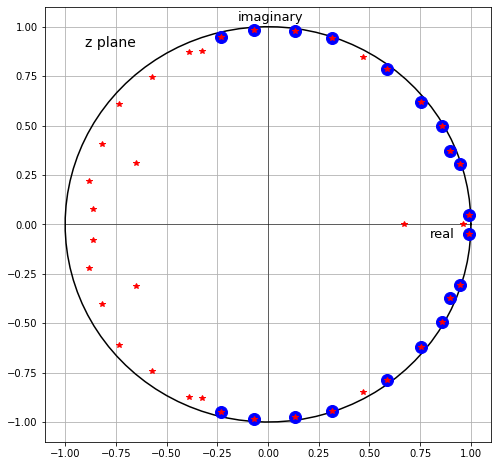

In [ ]:
num_coefs = 40;
num_formants = 10

a = librosa.lpc(speech_win, num_coefs)
poles = np.roots(a)

plt.figure(figsize=(8,8))
#plot unit circle
t = np.linspace(0,2*np.pi,100)
plt.plot(np.cos(t),np.sin(t),'k')
#plot axis lines
plt.plot([0,0],[-1,1],'k',linewidth=0.5)
plt.plot([-1,1],[0,0],'k',linewidth=0.5)
#mark poles selected for formants
sort_indexes = np.flip(np.argsort(np.abs(poles)))
poles_selected = poles[sort_indexes[:num_formants*2]]
X = [p.real for p in poles_selected]
Y = [p.imag for p in poles_selected]
plt.plot(X,Y, 'o', color='blue', markersize=12)
#plotting all poles
X = [p.real for p in poles]
Y = [p.imag for p in poles]
plt.plot(X,Y, '*', color='red')
plt.text(-0.9, 0.9, 'z plane', fontsize=14)
plt.text(0.8, -0.07, 'real', fontsize=13)
plt.text(-0.15, 1.03, 'imaginary', fontsize=13)
plt.grid();

**Inverse filtering:**

Once a filter is obtained that represents the LTI system, the excitation signal could be estimated using the inverse of the filter. Various analysis tasks can be considered on this excitation signal. For example in speech processing, [glottal inverse filtering](http://link.springer.com/content/pdf/10.1007/s12046-011-0041-5.pdf) is applied to estimate a glottal excitation signal which can be further analysed to detect voice pathologies at the glottis.  

Here we will only demonstrate that the spectrum can be decomposed into envelope and details using inverse filtering. 

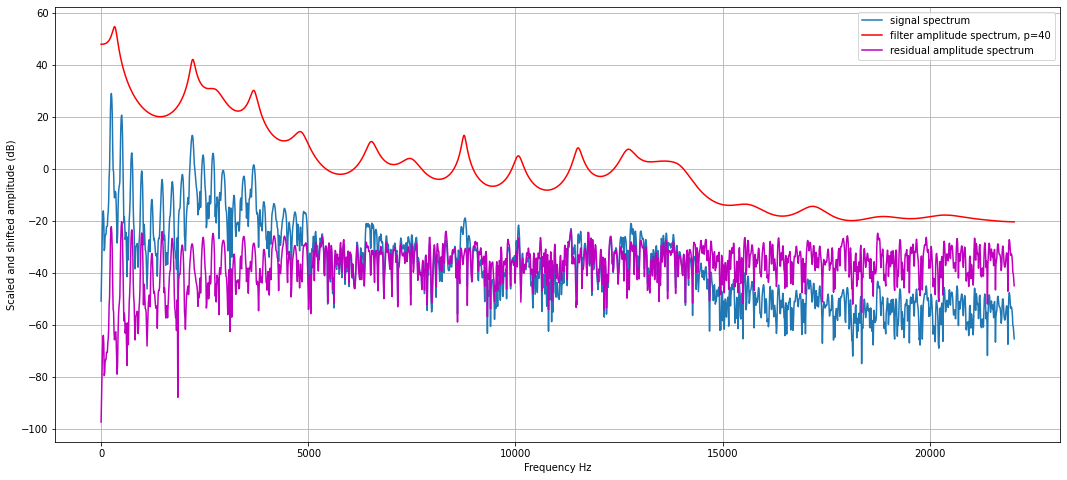

In [ ]:
def estimate_filter_apply_inverse_filtering(speech_sig, fs, num_coefs, fft_n):
  a = librosa.lpc(speech_sig, num_coefs)
  residual = lfilter(a, [1], speech_sig)
  w, h = freqz(1, a, fft_n // 2)
  filter_amp_spec = 20 * np.log10(np.abs(h))
  freq_axis = w * fs / (2*np.pi)
  residual_amp_spec = 20 * np.log10(np.abs(np.fft.fft(residual,n=fft_n)[:fft_n//2]))

  return freq_axis, filter_amp_spec, residual_amp_spec, residual

#Pick fft_n as a power of 2 bigger than the size of the window
fft_n = pow(2,int(np.log2(speech_win.size) + 1))
#Signal amplitude spectrum
amp_spec = 20 * np.log10(np.abs(np.fft.fft(speech_win,n=fft_n)[:fft_n//2]))
#Envelope and detail components of spectrum
num_coefs = 40
freq_axis, filter_amp_spec, residual_amp_spec, residual = estimate_filter_apply_inverse_filtering(speech_win, fs, num_coefs, fft_n)

#Plotting the components
#print("Spectrum plots shifted and scaled for better viewing of the seperate components")
plt.figure(figsize=(18,8))
plt.plot(freq_axis, amp_spec, label='signal spectrum');
plt.plot(freq_axis, filter_amp_spec, 'r', label='filter amplitude spectrum, p=40');
plt.plot(freq_axis, residual_amp_spec, 'm', label='residual amplitude spectrum');
plt.legend();
plt.xlabel("Frequency Hz");
plt.ylabel("Scaled and shifted amplitude (dB)");
plt.grid();

The residual spectrum is "white". Let's also plot the time domain signals to have a look at the waveform shapes.

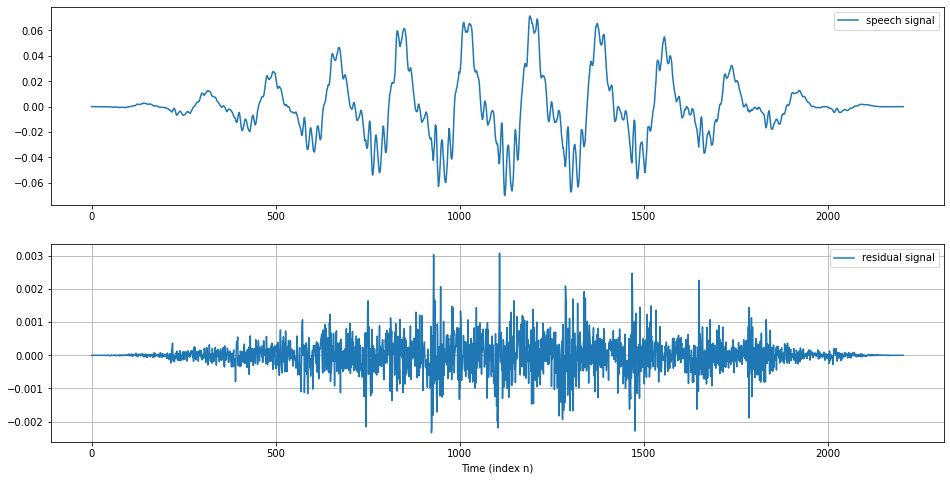

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(speech_win, label='speech signal');
plt.legend();
plt.subplot(2,1,2)
plt.plot(residual, label='residual signal');
plt.legend();
plt.xlabel("Time (index n)");
plt.grid();

**Line Spectral Frequencies (LSFs):**

In coding, [line spectral pairs or line spectral frequencies (LSFs)](https://en.wikipedia.org/wiki/Line_spectral_pairs)  are preferred over the polynomial coefficients for the LP filter for various reasons. First, they are more suitable for quantisation: filters obtained from quantized polinomial coefficients may be unstable, for LSFs the risk can be avoided. LSFs provide the chance for interpolation between filters during synthesis. Since LSF vector is simply a sorted array of numbers within [0,1] range, it is a suitable feature to represent spectrum for neural network based models. lsf2poly and poly2lsf functions perform conversion between these two sets of parameters. Below we provide a simple demonstration of the LSF representation.

LSF values:  [0.04073912 0.05688376 0.24893402 0.32237412 0.344737   0.46605102
 0.51591205 0.59582863 0.70172671 0.89020482 0.96530517 1.07797984
 1.22101855 1.27458237 1.39976908 1.52324883 1.63691084 1.71371366
 1.82048387 1.87436718 1.96247846 2.01817202 2.17512808 2.31147961
 2.4393365  2.54121713 2.68374657 2.7955804  2.91071648 3.01467181]


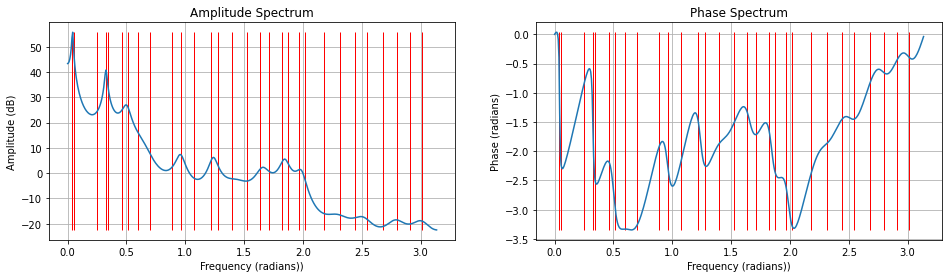

In [ ]:
def estimate_lsfs(speech_sig, num_coefs = 40):
  a = librosa.lpc(speech_sig, num_coefs)
  return np.array(poly2lsf(a))

def plot_filter(lsfs):
  '''Plots spectrum of a filter defined with its lsfs'''
  a = lsf2poly(lsfs)
  w, h = freqz(1, a)
  amp_spec = 20 * np.log10(abs(h))
  phase_spec = np.unwrap(np.angle(h))

  plt.figure(figsize=(16,4))
  plt.subplot(1,2,1)
  plt.title('Amplitude Spectrum')
  plt.plot(w, amp_spec)
  plt.ylabel('Amplitude (dB)')
  plt.xlabel('Frequency (radians))')
  plt.vlines(lsfs,np.min(amp_spec), np.max(amp_spec), 'r', linewidth = 1, label = 'LSF locations')
  plt.grid()
  plt.subplot(1,2,2)
  plt.title('Phase Spectrum')
  plt.plot(w, phase_spec)
  plt.ylabel('Phase (radians)')
  plt.xlabel('Frequency (radians))')
  plt.vlines(lsfs,np.min(phase_spec), np.max(phase_spec), 'r', linewidth = 1, label = 'LSF locations')
  plt.grid()

num_coefs = 30
lsfs = estimate_lsfs(speech_win, num_coefs=num_coefs)
plot_filter(lsfs)
print('LSF values: ', lsfs)

**Observation:** when LSF values are close, a resonance emerges

Let's compute LSFs frame by frame as done in STFT. We will plot spectrograms obtained from LSFs and the STFT of the signal for visual comparison

In [ ]:
#Parameters
frame_size = 512
hop_size = 256
num_lsfs = 30
expected_len = int((speech_sig.size - frame_size) / hop_size)
start_indexes = np.linspace(0,speech_sig.size - frame_size - 1,num=expected_len,endpoint=True).astype('int')

#Windowing
window_func = create_window(frame_size, name = 'hanning')
#Initializing arrays
synth_speech_sig = np.zeros_like(speech_sig)
synth_residual = np.zeros_like(speech_sig)

LSFS = np.zeros((expected_len, num_lsfs))

for window_index in range(expected_len):
    #WINDOWING
    start_index = start_indexes[window_index]
    windowed_sig = np.multiply(speech_sig[start_index : start_index + frame_size], window_func)
    
    #ANALYSIS: LSF parameter extraction
    LSFS[window_index] = estimate_lsfs(windowed_sig, num_coefs=num_lsfs)

In [ ]:
def spectrogram_from_lsfs(LSFS):
    freq_n = 512
    spectrogram = np.array([]).reshape(0, freq_n)
    for window_index in range(LSFS.shape[0]):
        lsfs = LSFS[window_index] 
        w, h = freqz(1, lsf2poly(lsfs), freq_n)
        spec_wind = 20 * np.log10(np.abs(h))
        spectrogram = np.vstack((spectrogram, spec_wind[-1::-1]))#reversed due to imshow origin being at top-left point
    return spectrogram.T

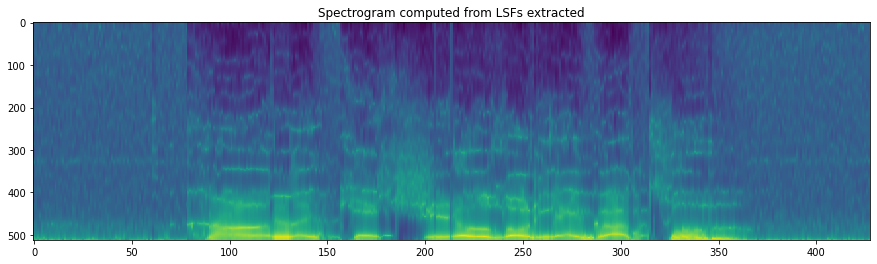

In [ ]:
#Plotting LSf-spectrogram
spectrogram = spectrogram_from_lsfs(LSFS)
plt.figure(figsize=(15,4))
plt.imshow(spectrogram, interpolation='nearest', aspect='auto')
plt.title('Spectrogram computed from LSFs extracted');

**Observation:** Indeed the spectrogram computed from the LSF coefficient carry information of the LTI system producing sound. Spectral details due to harmonics are excluded.

In [ ]:
def estimate_formant_freqs(LSFS, num_formants = 8):
  '''Estimates and return formant frequencies from roots of the LPC polinomial
  represented as line spectral frequencies 
  '''
  formants = []
  for window_index in range(LSFS.shape[0]):
    a = lsf2poly(LSFS[window_index])
    roots = np.roots(a)
    roots_r = np.abs(roots)
    roots_theta = np.angle(roots)
    #drop roots at negative frequencies
    positive_freq_indexes = roots_theta > 0
    roots_r = roots_r[positive_freq_indexes]
    roots_theta = roots_theta[positive_freq_indexes]
    #sort roots with respect to their norm
    sort_indexes = np.flip(np.argsort(roots_r))
    roots_r = roots_r[sort_indexes]
    roots_theta = roots_theta[sort_indexes]
    formants.append(roots_theta[:num_formants] * fs / (2 * np.pi))

  return np.array(formants)

formants = estimate_formant_freqs(LSFS)

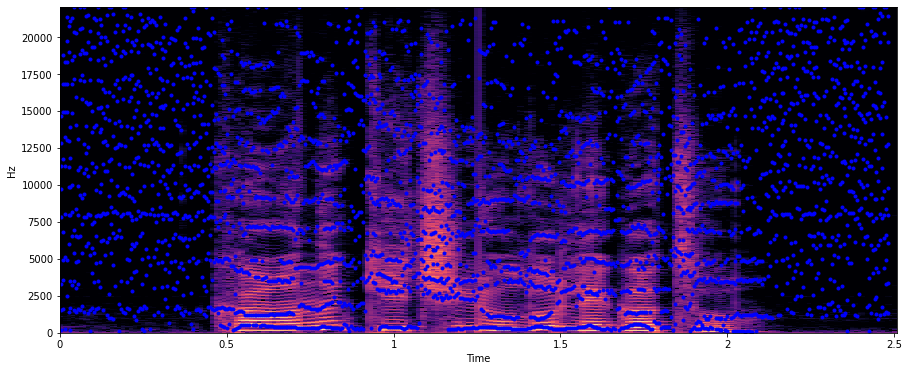

In [ ]:
#Plotting spectrogram using Librosa function
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(speech_sig)), ref=np.max)
fig = plt.figure(figsize=(15,6))
librosa.display.specshow(S_db, x_axis='time', y_axis='linear', sr = fs);
#Plotting formant frequencies as scatter plot
for i, formant_freqs in enumerate(formants):
  time = (i+0.5) * hop_size / fs
  for f in formant_freqs:
    plt.plot(time, f, 'b.')

We leave suppressing the formants during silences to you. 